In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 讀取訓練集和測試集
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')['country_destination']
y_test = y_train[:len(X_test)]

In [3]:
# 首次調整參數 設定要調整的參數和範圍
params = {
    'learning_rate': [0.1,0.3],
    'max_depth': [6,7,8,9,10],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'n_estimators': [25,50]
}

# 建立 XGBClassifier 模型
xgb_model  = XGBClassifier(tree_method='gpu_hist')

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# 使用 GridSearchCV 進行參數調整
# 使用 GridSearchCV 進行參數調整
grid_search = GridSearchCV(xgb_model, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(X_train, 
                y_train_encoded, 
                early_stopping_rounds=10, 
                eval_metric='mlogloss', 
                eval_set=[(X_test, label_encoder.transform(y_test))])


# 輸出最佳參數
print("Best parameters found: ", grid_search.best_params_)

# 使用最佳參數重新建立模型並預測
best_model = XGBClassifier(**grid_search.best_params_)
best_model.fit(X_train, y_train_encoded)
pred = best_model.predict(X_test)
xgb_pred = label_encoder.inverse_transform(pred)
print(xgb_pred.shape)


[0]	validation_0-mlogloss:2.29659
[1]	validation_0-mlogloss:2.16434
[2]	validation_0-mlogloss:2.05823
[3]	validation_0-mlogloss:1.97967
[4]	validation_0-mlogloss:1.91017
[5]	validation_0-mlogloss:1.84563
[6]	validation_0-mlogloss:1.79857
[7]	validation_0-mlogloss:1.74494
[8]	validation_0-mlogloss:1.71059
[9]	validation_0-mlogloss:1.66591
[10]	validation_0-mlogloss:1.63088
[11]	validation_0-mlogloss:1.58427
[12]	validation_0-mlogloss:1.55555
[13]	validation_0-mlogloss:1.52924
[14]	validation_0-mlogloss:1.51344
[15]	validation_0-mlogloss:1.48849
[16]	validation_0-mlogloss:1.47161
[17]	validation_0-mlogloss:1.45313
[18]	validation_0-mlogloss:1.43894
[19]	validation_0-mlogloss:1.41839
[20]	validation_0-mlogloss:1.40859
[21]	validation_0-mlogloss:1.39677
[22]	validation_0-mlogloss:1.38683
[23]	validation_0-mlogloss:1.37801
[24]	validation_0-mlogloss:1.37212
[0]	validation_0-mlogloss:2.34500
[1]	validation_0-mlogloss:2.19637
[2]	validation_0-mlogloss:2.10445
[3]	validation_0-mlogloss:2.04601

In [4]:
# 第二次 XGBClassifier 模型
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)

# xgb = XGBClassifier(max_depth=6, 
#                     learning_rate=0.3, 
#                     n_estimators=25,
#                     objective='multi:softprob', 
#                     subsample=0.5, 
#                     colsample_bytree=0.5,
#                     seed=0,
#                     tree_method='gpu_hist')

# xgb.fit(X_train, y_train_encoded)
# pred = xgb.predict(X_test)  
# xgb_pred = label_encoder.inverse_transform(pred)
# print(xgb_pred.shape)

In [5]:

def metrics_sklearn(y_valid, y_pred):
    accuracy = accuracy_score(y_valid, y_pred)
    print('AccuracyL %.2f%%' % (accuracy * 100))

    precision = precision_score(y_valid, y_pred, average='macro')
    print('Precision: %.2f%%' % (precision *100))

    recall = recall_score(y_valid, y_pred, average='macro')
    print('Recall: %.2f %%' % (recall *100))

    f1 = f1_score(y_valid, y_pred, average='macro')
    print('F1: %.2f%%' % (f1*100))
    

In [6]:
metrics_sklearn(y_test, xgb_pred)

AccuracyL 52.24%
Precision: 6.97%
Recall: 8.31 %
F1: 6.07%


In [7]:
submit = pd.read_csv("./airbnb-recruiting-new-user-bookings/sample_submission_NDF.csv.zip")
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       62096 non-null  object
 1   country  62096 non-null  object
dtypes: object(2)
memory usage: 970.4+ KB


In [9]:
test_df  = pd.read_csv('./airbnb-recruiting-new-user-bookings/test_users.csv.zip')


test_id = test_df['id'].values

test_id

array(['5uwns89zht', 'jtl0dijy2j', 'xx0ulgorjt', ..., 'fa6260ziny',
       '87k0fy4ugm', '9uqfg8txu3'], dtype=object)

In [11]:
import numpy as np
pred_y = best_model.predict_proba(X_test)

#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(test_id)):
    idx = test_id[i]
    ids += [idx] * 5
    cts += label_encoder.inverse_transform(np.argsort(pred_y[i])[::-1])[:5].tolist()
# Generate submission
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('sub.csv',index=False)


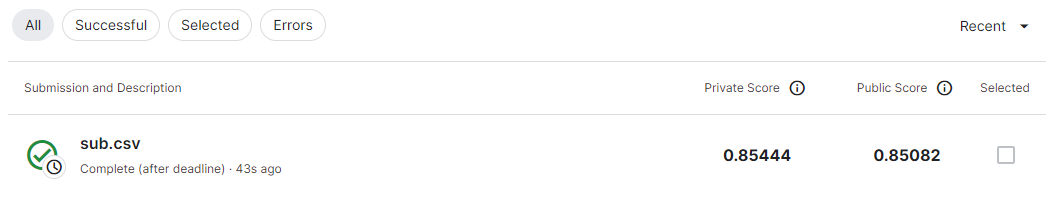